## Additional Learning Resources
Refer to [scikit-learn documentation](https://scikit-learn.org/stable/) and the [Pandas user guide](https://pandas.pydata.org/docs/) for detailed explanations of the functions used in this notebook.
For a quick refresher on splitting data:
```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```


# Decision Trees 🌲

After this session you will 
- develop a basic intuition underlying one algorithm of non-linear classification ("CART")
- be able to apply the Decision Trees Classifier to your own datasets
- explain in your own words what the pros and cons of the Decision Trees Classifier are


Note:
- In general, there is a Classification Tree-model and one for Regression in sklearn => we will only talk about the **classification** model.

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv("../data/penguins_simple.csv", sep = ";")

In [3]:
df.head(2)

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
0,Adelie,39.1,18.7,181.0,3750.0,MALE
1,Adelie,39.5,17.4,186.0,3800.0,FEMALE


In [4]:
X = df[["Culmen Length (mm)", "Body Mass (g)"]]
y = df["Species"]
X.shape, y.shape

((333, 2), (333,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((249, 2), (84, 2), (249,), (84,))

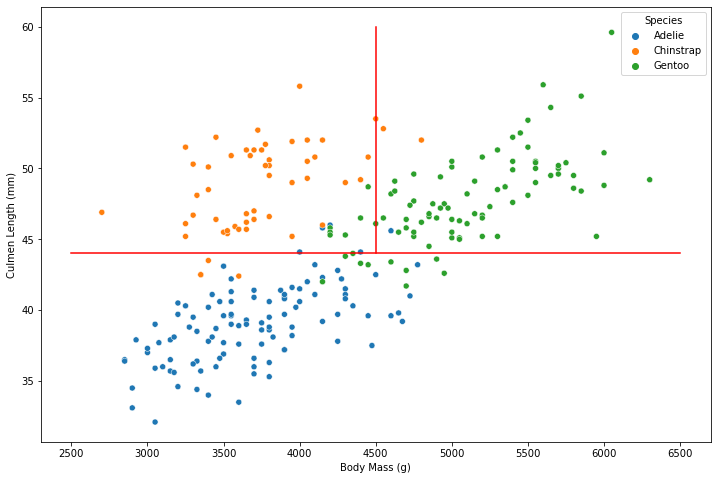

In [6]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x = X_train["Body Mass (g)"],
    y = X_train["Culmen Length (mm)"],
    hue = y
);


plt.plot(
    [2500, 6500], [44,44], color = "red"
);

plt.plot(
    [4500, 4500], [44,60], color = "red"
);

In [7]:
species = []

for idx, sample in X_train.iterrows():
    if sample["Culmen Length (mm)"] < 43:
        species.append("Adelie")
    else:
        if sample["Body Mass (g)"] < 4500:
            species.append("Chinstrap")
        else:
            species.append("Gentoo")
    


In [8]:
len(species)

249

In [9]:
round(accuracy_score(y_train, species), 2)

0.89

## Gini Impurity

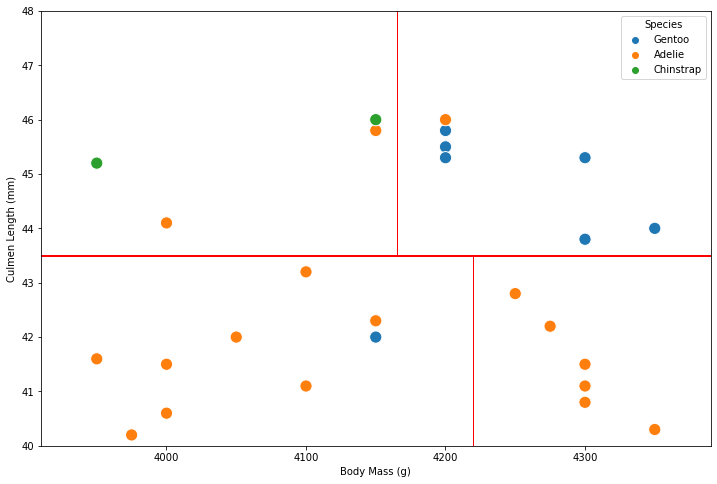

In [10]:
plt.figure(figsize=(12,8))
plot = sns.scatterplot(x=X_train["Body Mass (g)"], y=X_train["Culmen Length (mm)"], hue=y_train, s=150)
plt.axis((3910, 4390, 40, 48))
plt.plot([3910, 4390],[43.5,43.5], linewidth=2, color="red") #horizontal
plt.plot([4220, 4220],[0,43.5], linewidth=1, color="red") #bottom
plt.plot([4165, 4165],[43.5,48], linewidth=1, color="red") #top

GINI =  $\sum\nolimits_{k=1}^K(p_{k})(1 - p_{k})$

K = classes, 
p = Proportion of points belonging to class k

Let's denote the classes this way:
- "1" = "Adelie"
- "2" = "Gentoo"
- "3" = "Chinstrap"

In [11]:
# lower left corner:
p1 = 8/9
p2 = 1/9

gini_lower_left = p1*(1-p1) + p2*(1-p2)
round(gini_lower_left, 2)

0.2

In [12]:
# lower right corner:
p1 = 1
p2 = 0


gini_lower_right = p1*(1-p1) + p2*(1-p2)
gini_lower_right

0

In [13]:
# upper left corner:
p1 = 0.5
p3 = 0.5

gini_upper_left = p1*(1-p1) + p3*(1-p3)
round(gini_upper_left, 2)

0.5

In [14]:
# upper right corner:
p1 = 1/7
p2 = 6/7

gini_upper_right = p1*(1-p1) + p2*(1-p2)
round(gini_upper_right, 2)

0.24

In order to find the final gini-value, we need to ponderate by likelihood of randomly selecting each class for the complete lower node (left and right) and then add them. The same thing applies to the upper half, which we won't do here...adding both ponderating values (lower node -gini and upper node-gini) gives us our final gini-value. The **lower this value**, the **better** the model performs in classifying samples. 

In [15]:
# Evaluation of the split vertical bottom: does this split create two "good" nodes? 
gini_impurity = 9/15*gini_lower_left + 6/15*gini_lower_right
round(gini_impurity, 3) 

0.119

The model will continue to split, split, split (based on different features and thresholds) until all leaves have a gini = 0 (i.e. they are all "pure"). Problem is: it will overfit, so we need to counter tendency of overfitting by defining hyperparameters (especially: max_depth).

In summary: finding the best thresholds ("splitting the data") will require to define them such that Gini is minimized.

## Luckily, there is a Decision Tree Model in Sklearn that will do all the hard work for us!

#### Train the model

In [16]:
clf_Decision_Tree = DecisionTreeClassifier(max_depth=2, random_state=42)

In [17]:
clf_Decision_Tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

#### Make predictions

In [18]:
DT_predictions = clf_Decision_Tree.predict(X_train)

In [19]:
round(accuracy_score(y_train, DT_predictions), 3)

0.928

In [20]:
DT_predictions = clf_Decision_Tree.predict(X_test)

In [21]:
round(accuracy_score(y_test, DT_predictions), 3)

0.929

#### Plot the tree

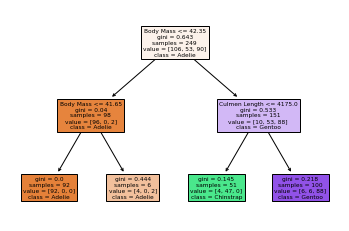

In [22]:
t = plot_tree(clf_Decision_Tree, feature_names=["Body Mass", "Culmen Length"],  class_names=["Adelie", "Chinstrap", "Gentoo"], filled=True)

## The Decision Tree Algorithm
`split(node, {samples})`:

1. Determines the best feature for splitting the data*
2. Determines the best value / threshold for splitting*
    - Entropy (Computer Science) - ID3 Algorithm
    - Gini Impurity (Economics) - CART Algorithm
3. Create 2 children nodes (binary)
4. Split the {samples} across those nodes
5. Recurse! For each children node,
    - IF subset is PURE:
        - STOP!
    - ELSE:
        - `split(child_node, {subset})`

## Entropy

4 samples --> 4, 0 (100% Purity) -> Entropy = 0.0

4 samples --> 2, 2 (100% Impurity) -> Entropy = 1.0 (Maximum for binary classification)

In [23]:
m = DecisionTreeClassifier(max_depth=2, criterion='entropy')  
m.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

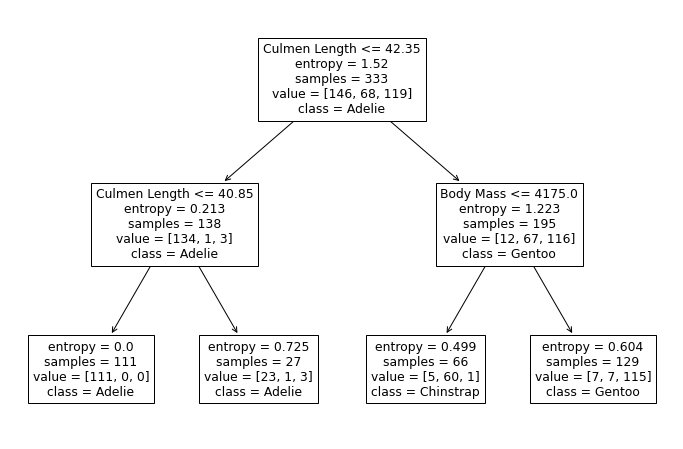

In [24]:
plt.figure(figsize=(12, 8))
t = plot_tree(m, feature_names=["Culmen Length", "Body Mass"], class_names=['Adelie', 'Chinstrap', 'Gentoo'])

**Starting Entropy (at the root node)**

In [25]:
P_Adelie = (146) / (146+68+119)
P_Chin = (68) / (146+68+119)
P_Gent = (119) / (146+68+119)

entropy_root_node = -P_Adelie * np.log2(P_Adelie) - P_Chin * np.log2(P_Chin) - P_Gent * np.log2(P_Gent)
entropy_root_node

1.5200835543530913

**Entropy after the first question / split**

In [26]:
P_Adelie = (134)/(134+1+3)
P_Chin = (1)/(134+1+3)
P_Gent = (3)/(134+1+3)

entropy_split_1a = -P_Adelie * np.log2(P_Adelie) - P_Chin * np.log2(P_Chin) - P_Gent * np.log2(P_Gent)
entropy_split_1a

0.21279373921653882

In [27]:

P_Adelie = (12)/(12+67+116)
P_Chin = (67)/(12+67+116)
P_Gent = (116)/(12+67+116)

entropy_split_1b = -P_Adelie * np.log2(P_Adelie) - P_Chin * np.log2(P_Chin) - P_Gent * np.log2(P_Gent)
entropy_split_1b

1.2228517434720567

Then, to calculate the **INFORMATION GAIN of the first question**, you **take the weighted sum of the resulting entropies of both child nodes, and subtract that from the original starting entropy** (i.e. entropy in the root node):

In [28]:
Gain = entropy_root_node - (134+1+3)/(146+68+120)*entropy_split_1a - (12+67+117)/(146+68+120)*entropy_split_1b
Gain

0.7145611659327157


The Difference in entropy before the split and the entropy after the split is called `information gain`. We can think of this as the drop in entropy (which is what we want, b/c entropy basically means uncertainty), or the increase in information.

And the reason the first question was chosen (i.e. "is the Culmen shorter than 42.35 millimeters?") is **because that was the question that resulted in the largest information gain (0.71) compared to all other possible questions**. The algorithm keeps going as long as it can find questions that increase the information gain.

## When should I use a Decision tree? 🌳   

**Advantages:** 
- intuitive understanding, can be visualized
- requires little data preparation

**Disadvantages:**
- prone to overfitting => tune hyperparams, esp. "max_depth" and "min_samples_leaf"
- tends to be biased towards "majority group" in imbalanced datasets => up/downsample dataset